In [1]:
%matplotlib notebook
from ipynb.fs.defs.utilities import *

In [2]:
# Customized color bar 1 (2 colors)

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(70/256, 177/256, N)
vals[:, 1] = np.linspace(130/256, 78/256, N)
vals[:, 2] = np.linspace(180/256, 132/256, N)
newcmp = ListedColormap(vals)

# Customized color bar 2 (3 colors)
 
vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [214, 244, 255]
col3 = [227, 158, 33]
 
vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2))

cmp_blue_3col = ListedColormap(vals)
cmp_blue_3col_inv = ListedColormap(cmp_blue_3col.colors[::-1])

# Customized color bar 3 (4 colors)

vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))
vals_seg3 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [227, 158, 33]
col3 = [255, 236, 203]
col4 = [138, 115, 86]
 
vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals_seg3[:, 0] = np.linspace(col3[0]/256, col4[0]/256, N)
vals_seg3[:, 1] = np.linspace(col3[1]/256, col4[1]/256, N)
vals_seg3[:, 2] = np.linspace(col3[2]/256, col4[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2,vals_seg3))

cmp_blue_4col = ListedColormap(vals)
cmp_blue_4col_inv = ListedColormap(cmp_blue_4col.colors[::-1])

# Experimental evaluation of the Navion eMNS

We provide here an experimental validation of our tools on the Navion eMNS, a three-coil electromagnetic navigation systems.

## Evaluate available field with model

In [3]:
# Load system calibration
rp = rospkg.RosPack()
cal_path_navion = os.path.join('models/Navion_2_Calibration_24-02-2020.yaml')

model_navion = ForwardModelMPEM()
model_navion.setCalibrationFile(cal_path_navion)

In [4]:
def ComputeMaxFieldInPos(model_mns,position,Imin,Imax):
    
    J = model_mns.getFieldActuationMatrix(position)

    #Check feasibility at each grid point            
    N, d = HyperPlaneShiftingMethod(J,Imin,Imax)

    bmax = np.min(d)

    return bmax

def ComputeMaxField(Nx,Ny,Nz,pmin,pmax,Imin,Imax,model_mns):

    p_ws = np.empty((0,3))
    max_field_mT = np.array([])

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)
    posz_v = np.linspace(pmin[2], pmax[2], Nz, endpoint=True) 


    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):
                
                                
                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]

                position = np.array([posx_v[i],posy_v[j],posz_v[k]])
                bmax = ComputeMaxFieldInPos(model_mns,position,Imin,Imax)
                
                p_ws = np.append(p_ws, [position], axis=0)                
                max_field_mT = np.append(max_field_mT, [bmax*1000], axis=0)
                
    return p_ws, max_field_mT

In [5]:
#Horizontal plane
Nx = 100
Ny = 100
Nz = 1

#Build initial box
pmin_hor = np.array([-0.25,-0.315,0.])
pmax_hor = np.array([0.25,0.185,0.])

p_hor, max_field_hor = ComputeMaxField(Nx,Ny,Nz,pmin_hor,pmax_hor,-35,35,model_navion)

x_hor = np.linspace(pmin_hor[0], pmax_hor[0], 70, endpoint=True)
y_hor = np.linspace(pmin_hor[1], pmax_hor[1], 70, endpoint=True)
z_hor = griddata((p_hor[:,0], p_hor[:,1]), max_field_hor/1000, (x_hor[None,:], y_hor[:,None]), method='linear')

<IPython.core.display.Javascript object>


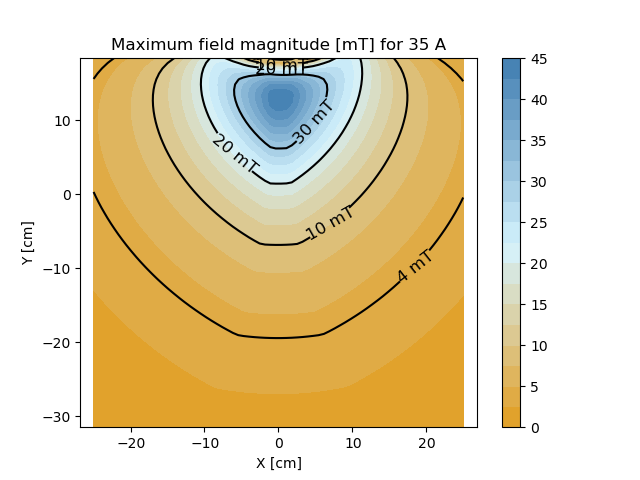

In [6]:
fig = plt.figure()

ax = fig.gca()
cs = ax.contour(x_hor*100, y_hor*100, z_hor*1000, [4, 10 ,20, 30], alpha=1.0, colors='black', vmin=max_field_hor.min(), vmax=max_field_hor.max())
s2 = ax.contourf(x_hor*100, y_hor*100, z_hor*1000, 20, cmap=cmp_blue_3col_inv, alpha=1.0, vmin=max_field_hor.min(), vmax=max_field_hor.max())

ax.clabel(cs, inline=1, fontsize=12, fmt='%1.0f mT')

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_xlim(pmin_hor[0],pmax_hor[0])
ax.set_ylim(pmin_hor[1],pmax_hor[1])
ax.set_title('Maximum field magnitude [mT] for 35 A')
ax.axis('equal')

fig.colorbar(s2)

plt.show()

## WFW and DA distance

In [7]:
#Define requirements for catheter steering

Br = 1.3 #magnet remanence [T]
l = 5.0e-3 #magnet length [m]
d = 2.33e-3 #outer diameter [m]
mu0 = 4*math.pi*(10**(-7)) # permeability of vacuum [H/m]
m = (math.pi*(d/2)**2*l*Br)/mu0 #magnetic dipole moment [Nm/T]

theta_des = 120 * math.pi/180 # desired max tip angle [rad]
L = 4.0e-2 #length of the catheter [m]
E = 15.0e6 #Young's modulus of the catheter [Pa]
I = math.pi * (d/2)**4 /4 #second moment of area of the cross-section [m^4]

#Compute maximum torque and field magnitude
tmax = theta_des * E * I / L #[N.m]
bmax = tmax / m #[T]

bmax = 0.015

print(tmax)
print(bmax)

0.001136275033022366
0.015000000000000001


In [8]:
#Horizontal plane
Nx = 100
Ny = 100
Nz = 1

#Build initial box
pmin_hor = np.array([-0.25,-0.2,0.])
pmax_hor = np.array([0.25,0.2,0.])

p_ws_3_bg_x_in, p_ws_3_bg_x_out, p_ws_3_bg_x_side, kappa_3_bg_x, mu_3_bg_x, gci_3_bg_x, ad_3_bg_x = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin_hor,pmax_hor,-bmax,bmax,-35,35,model_navion,'ellipsoid')
p_hor, max_field_hor = ComputeMaxField(Nx,Ny,Nz,pmin_hor,pmax_hor,-35,35,model_navion)

x_hor = np.linspace(pmin_hor[0], pmax_hor[0], 70, endpoint=True)
y_hor = np.linspace(pmin_hor[1], pmax_hor[1], 70, endpoint=True)
z_hor = griddata((p_hor[:,0], p_hor[:,1]), max_field_hor/1000, (x_hor[None,:], y_hor[:,None]), method='linear')

<IPython.core.display.Javascript object>


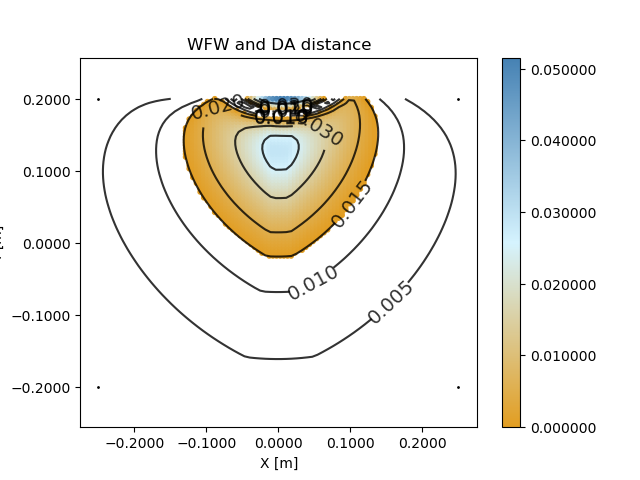

In [9]:
fig = plt.figure()

ax = fig.gca()
cs = ax.contour(x_hor, y_hor, z_hor, [0.005, 0.01, 0.015, 0.020, 0.030, 0.040], alpha=0.8, colors='black', vmin=max_field_hor.min()/1000, vmax=max_field_hor.max()/1000)
ax.clabel(cs, inline=1, fontsize=14, fmt='%1.3f')

s = ax.scatter(p_ws_3_bg_x_in[:,0],p_ws_3_bg_x_in[:,1],alpha=1., s = 10, c=ad_3_bg_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_bg_x.max())
ax.scatter(p_ws_3_bg_x_side[:,0],p_ws_3_bg_x_side[:,1], color='black',alpha=1., s = 1., rasterized=True)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(pmin_hor[0],pmax_hor[0])
ax.set_ylim(pmin_hor[1],pmax_hor[1])
ax.set_title('WFW and DA distance')
ax.axis('equal')

plt.colorbar(s)
plt.show()

## Experimental validation

### Functions for data processing

In [10]:
def PrepareData(field_meas_topic,des_current_topic):
# Prepare data and return max field averaged measurement in mT at vertices of the polytope  

    # Get time of first current command
    t0 = des_current_topic.index[0]

    # Build time vector
    time_command = des_current_topic.index

    # Add offset for time measurement
    dt = 4.5e9 #offset time for measure
    time = time_command + dt

    # Average data
    meas_field_avg = field_meas_topic.rolling(window=2).mean()

    # Resample data
    meas_field_rs = field_meas_topic.reindex(time[0:8],method='bfill')
    
    bmeas = meas_field_rs.to_numpy()*1000 #measurement in mT
    
    return bmeas

In [11]:
def EvaluateMaxInSensorPos(plate_height,model_mns,Imin,Imax):
# Prepare position transformation
    
    x_corr = 0.
    y_corr = 0.01
    t = [0.120+x_corr,0.20+y_corr,-plate_height] #Translation from calcube to mns frame

    Tcalcube_mns = np.array([[ 1., 0.,  0., t[0]],[0.,  1., 0., t[1]],[0.,0.,1.,t[2]],[0. , 0., 0. ,1.]])
    Tmns_calcube = np.linalg.inv(Tcalcube_mns)

    nx = 11
    ny = 11
    spacing = 0.024
    pos0 = np.array([0.,0.,0.])
    pos = np.empty((0,3))
    bmax = np.array([])

    # Generate list of positions in mns frame corresponding to sensors and evaluate max field in T at this location

    for X in range(nx):
        for Y in range(ny):

            # Position
            cX = spacing * (nx - 1) / 2.0
            cY = spacing * (ny - 1) / 2.0

            position_calcube_hom = np.array([X * spacing ,Y * spacing, 0., 1.])
            position_mns_hom = np.matmul(Tmns_calcube,position_calcube_hom)

            pos = np.append(pos, [position_mns_hom[0:3]], axis=0) 
            
            temp = ComputeMaxFieldInPos(model_mns,position_mns_hom[0:3],Imin,Imax)

            bmax = np.append(bmax, [temp], axis=0) 
        
    return pos, bmax

In [12]:
def MinMaxField(bmeas):
# Compute max field based on sensors measurement

    # Return min field and maximum field within the hull
    
    hull = ConvexHull(bmeas)
    simplices = hull.simplices
    org_triangles = [bmeas[s] for s in simplices]
    
    #Min
    eq = hull.equations
    dist_tri = np.abs(eq[:,3])
    
    i_min = np.argmin(dist_tri)
    bmin = dist_tri.min() * eq[i_min,0:3]
    
    #Max
    dist_simpl = np.linalg.norm(bmeas,axis=1)
    
    i_max = np.argmax(dist_simpl)
    bmax = bmeas[i_max,:]
    
    return bmin, bmax

In [13]:
# Compute for every sensors
def ComputeOrderedMinMaxMag(bmeas):

    bmin = np.empty((0,3))
    bmax = np.empty((0,3))

    for i in range(125):


        bmin_i, bmax_i = MinMaxField(bmeas[:,3*i:3*i+3])


        bmin = np.append(bmin, [bmin_i[0:3]], axis=0) 
        bmax = np.append(bmax, [bmax_i[0:3]], axis=0) 

    # Compute norms

    bmin_mag = np.transpose(np.reshape(np.apply_along_axis(np.linalg.norm, 1, bmin),(-1,1)))
    bmax_mag = np.transpose(np.reshape(np.apply_along_axis(np.linalg.norm, 1, bmax),(-1,1)))

    # Re-order sensors to match positions list

    order = np.loadtxt("experimental_data/sensors_connection.txt", dtype=int)

    bmin_mag_ordered = bmin_mag[:,order[:,0]-1] #reordering sensors to match order of tested position
    bmax_mag_ordered = bmin_mag[:,order[:,0]-1] #reordering sensors to match order of tested position
    
    return bmin_mag_ordered[0,0:121], bmax_mag_ordered[0,0:121]

### Results for neutral plane

In [14]:
bag = rosbag.Bag('experimental_data/measures_navion_pos_0.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
des_current =  topic_to_df(bag,'/navion/target_currents','mag_msgs/CurrentsStamped')
bmeas = PrepareData(meas_field,des_current)
temp = des_current.to_numpy()
current_target = temp[0:8,:]

<IPython.core.display.Javascript object>


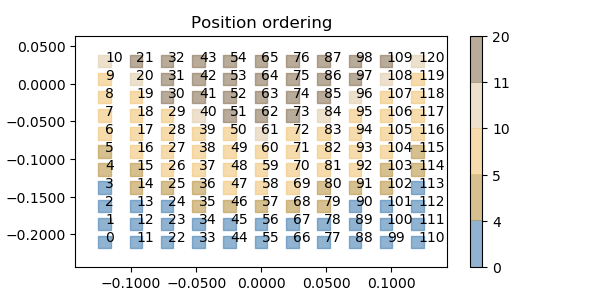

In [15]:
# Compute for all sensors
bmin_mag_ordered, bmax_mag_ordered = ComputeOrderedMinMaxMag(bmeas)

pos0, bmax0 = EvaluateMaxInSensorPos(0.,model_navion,-35,35)

vals=[0,4,5,10,11,20]
norm = mpl.colors.BoundaryNorm(vals, cmp_blue_4col.N)

fig = plt.figure(figsize=(6, 3))

ax = fig.gca()
s = ax.scatter(pos0[:,0],pos0[:,1], c=bmin_mag_ordered, marker="s", cmap = cmp_blue_4col, norm=norm, alpha=0.6,s = 80, rasterized=True)
ax.set_title('Position ordering')
fig.colorbar(s, ax=ax,shrink=1.)


n = np.arange(121)
for i, txt in enumerate(n):
    ax.annotate(txt, (pos0[i,0], pos0[i,1]))

plt.show()

4.708877206591866
6.8522642744219056
4.506140112990859


<IPython.core.display.Javascript object>


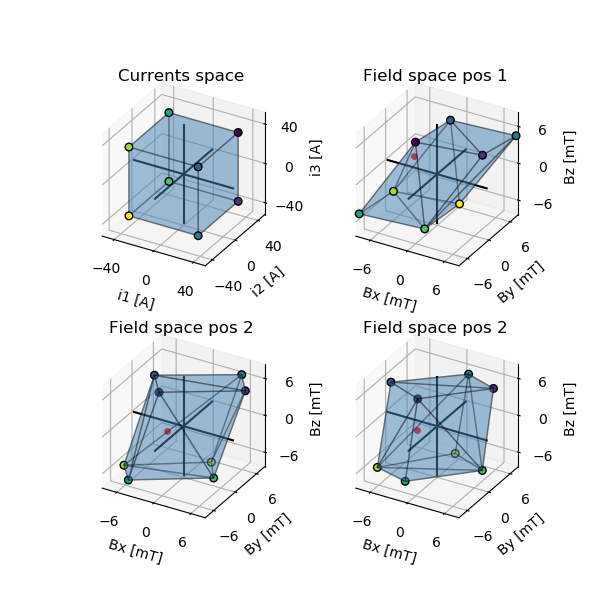

[-3.64665296 -0.12283185  1.89530858]
[-3.97979367  2.16184765 -3.07681527]
[-3.6389897   0.51711959 -1.87646149]


In [16]:
order = np.loadtxt("experimental_data/sensors_connection.txt", dtype=int)

id1 = 15
id2 = 59
id3 = 103


print(bmin_mag_ordered[id1])
print(bmin_mag_ordered[id2])
print(bmin_mag_ordered[id3])

ilim = 50
blim = 8

fig = plt.figure(figsize=(6, 6))

# Current space

ax = fig.add_subplot(221,projection='3d', proj_type = 'ortho')
plotHull(ax,current_target,'steelblue',0.3,inter=0.1,edge_color='black')
ax.scatter(current_target[:,0],current_target[:,1], current_target[:,2], alpha=1.,s=30, edgecolors="black", c=np.arange(8), cmap = 'viridis')
ax.set_xlabel('i1 [A]')
ax.set_ylabel('i2 [A]')
ax.set_zlabel('i3 [A]')
ax.set_xlim(-ilim, ilim)
ax.set_ylim(-ilim, ilim)
ax.set_zlim(-ilim, ilim)
ax.plot([-ilim,ilim], [0.,0.], [0.,0.],color='black')
ax.plot([0.,0.],[-ilim,ilim],  [0.,0.],color='black')
ax.plot([0.,0.],[0.,0.],[-ilim,ilim],color='black')
ax.set_title("Currents space")

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))


# Check at different positions

# Position 1
id_sens =  order[id1,0]

bmin, bmax = MinMaxField(bmeas[:,3*id_sens:3*id_sens+3])
print(bmin)

ax = fig.add_subplot(222,projection='3d', proj_type = 'ortho')
plotHull(ax,bmeas[:,3*id_sens:3*id_sens+3],'steelblue',0.3,inter=0.1,edge_color='black')
ax.scatter(bmin[0],bmin[1], bmin[2], color='red',alpha=1.,s=15)
ax.scatter(bmeas[:,3*id_sens],bmeas[:,3*id_sens+1],bmeas[:,3*id_sens+2], alpha=1.,s=30, edgecolors="black", c=np.arange(8), cmap = 'viridis')
ax.set_xlabel('Bx [mT]')
ax.set_ylabel('By [mT]')
ax.set_zlabel('Bz [mT]')
ax.set_xlim(-blim, blim)
ax.set_ylim(-blim, blim)
ax.set_zlim(-blim, blim)
ax.plot([-blim,blim], [0.,0.], [0.,0.],color='black')
ax.plot([0.,0.],[-blim,blim],  [0.,0.],color='black')
ax.plot([0.,0.],[0.,0.],[-blim,blim],color='black')
ax.set_title("Field space pos 1")

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

# Position 2
id_sens = order[id2,0]

bmin, bmax = MinMaxField(bmeas[:,3*id_sens:3*id_sens+3])
print(bmin)

ax = fig.add_subplot(223,projection='3d', proj_type = 'ortho')
plotHull(ax,bmeas[:,3*id_sens:3*id_sens+3],'steelblue',0.3,inter=0.1,edge_color='black')
ax.scatter(bmin[0],bmin[1], bmin[2], color='red',alpha=1.,s=15)
ax.scatter(bmeas[:,3*id_sens],bmeas[:,3*id_sens+1],bmeas[:,3*id_sens+2], alpha=1.,s=30, edgecolors="black", c=np.arange(8), cmap = 'viridis')
ax.set_xlabel('Bx [mT]')
ax.set_ylabel('By [mT]')
ax.set_zlabel('Bz [mT]')
ax.set_xlim(-blim, blim)
ax.set_ylim(-blim, blim)
ax.set_zlim(-blim, blim)
ax.plot([-blim,blim], [0.,0.], [0.,0.],color='black')
ax.plot([0.,0.],[-blim,blim],  [0.,0.],color='black')
ax.plot([0.,0.],[0.,0.],[-blim,blim],color='black')
ax.set_title("Field space pos 2")

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))


# Position 3
id_sens = order[id3,0]

bmin, bmax = MinMaxField(bmeas[:,3*id_sens:3*id_sens+3])
print(bmin)

ax = fig.add_subplot(224,projection='3d', proj_type = 'ortho')
plotHull(ax,bmeas[:,3*id_sens:3*id_sens+3],'steelblue',0.3,inter=0.1,edge_color='black')
ax.scatter(bmin[0],bmin[1], bmin[2], color='red',alpha=1.,s=15)
ax.scatter(bmeas[:,3*id_sens],bmeas[:,3*id_sens+1],bmeas[:,3*id_sens+2], alpha=1.,s=30, edgecolors="black", c=np.arange(8), cmap = 'viridis')
ax.set_xlabel('Bx [mT]')
ax.set_ylabel('By [mT]')
ax.set_zlabel('Bz [mT]')
ax.set_xlim(-blim, blim)
ax.set_ylim(-blim, blim)
ax.set_zlim(-blim, blim)
ax.plot([-blim,blim], [0.,0.], [0.,0.],color='black')
ax.plot([0.,0.],[-blim,blim],  [0.,0.],color='black')
ax.plot([0.,0.],[0.,0.],[-blim,blim],color='black')
ax.set_title("Field space pos 2")

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

plt.show()

<IPython.core.display.Javascript object>


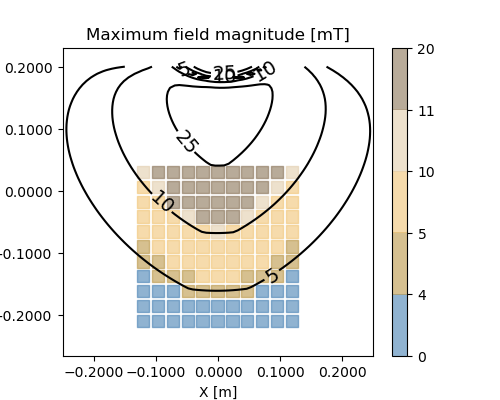

In [17]:
# Compare to sim

fig = plt.figure(figsize=(5, 4))

ax = fig.gca()
cs = ax.contour(x_hor, y_hor, z_hor*1000, [5, 10, 25], alpha=1.0, colors='black', vmin=max_field_hor.min(), vmax=max_field_hor.max())
ax.clabel(cs, inline=1, fontsize=14, fmt='%1.0f')
s = ax.scatter(pos0[:,0],pos0[:,1], c=bmin_mag_ordered, marker="s", cmap = cmp_blue_4col, norm=norm, alpha=0.6,s = 80, rasterized=True)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

ax.set_title('Maximum field magnitude [mT]')
ax.axis('equal')
fig.colorbar(s, ax=ax,shrink=1.)

plt.show()

### Results for other planes

In [18]:
bag = rosbag.Bag('experimental_data/measures_navion_pos_1.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
des_current =  topic_to_df(bag,'/navion/target_currents','mag_msgs/CurrentsStamped')
bmeas1 = PrepareData(meas_field,des_current)

bag = rosbag.Bag('experimental_data/measures_navion_pos_m1.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
des_current =  topic_to_df(bag,'/navion/target_currents','mag_msgs/CurrentsStamped')
bmeasm1 = PrepareData(meas_field,des_current)

bag = rosbag.Bag('experimental_data/measures_navion_pos_2.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
des_current =  topic_to_df(bag,'/navion/target_currents','mag_msgs/CurrentsStamped')
bmeas2 = PrepareData(meas_field,des_current)

bag = rosbag.Bag('experimental_data/measures_navion_pos_m2.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
des_current =  topic_to_df(bag,'/navion/target_currents','mag_msgs/CurrentsStamped')
bmeasm2 = PrepareData(meas_field,des_current)

bmin1_mag_ordered, bmax1_mag_ordered = ComputeOrderedMinMaxMag(bmeas1)
bmin2_mag_ordered, bmax2_mag_ordered = ComputeOrderedMinMaxMag(bmeas2)
bminm1_mag_ordered, bmaxm1_mag_ordered = ComputeOrderedMinMaxMag(bmeasm1)
bminm2_mag_ordered, bmaxm2_mag_ordered = ComputeOrderedMinMaxMag(bmeasm2)

posm2, bmaxm2 = EvaluateMaxInSensorPos(-57.6e-3,model_navion,-35,35)
posm1, bmaxm1 = EvaluateMaxInSensorPos(-28.8e-3,model_navion,-35,35)
pos0, bmax0 = EvaluateMaxInSensorPos(0.,model_navion,-35,35)
pos1, bmax1 = EvaluateMaxInSensorPos(28.8e-3,model_navion,-35,35)
pos2, bmax2 = EvaluateMaxInSensorPos(57.6e-3,model_navion,-35,35)

bmin = np.min((bminm1_mag_ordered.min(),bminm2_mag_ordered.min(), bmin_mag_ordered.min(), bmin1_mag_ordered.min(),bmin2_mag_ordered.min()))
bmax = np.max((bminm1_mag_ordered.max(),bminm2_mag_ordered.max(), bmin_mag_ordered.max(), bmin1_mag_ordered.max(),bmin2_mag_ordered.max()))

<IPython.core.display.Javascript object>


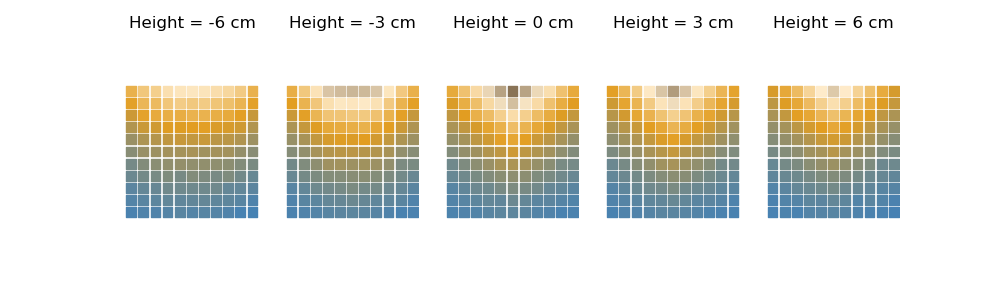

In [19]:
fig = plt.figure(figsize=(10, 3))

# Pos -2
ax = fig.add_subplot(151)
s = ax.scatter(posm2[:,0]*100,posm2[:,1]*100, c=bminm2_mag_ordered, marker="s", cmap = cmp_blue_4col, vmin=bmin, vmax=bmax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = -6 cm')
ax.axis('equal')
ax.axis('off')

# Pos -1
ax = fig.add_subplot(152)
s = ax.scatter(posm1[:,0]*100,posm1[:,1]*100, c=bminm1_mag_ordered, marker="s", cmap = cmp_blue_4col,vmin=bmin, vmax=bmax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = -3 cm')
ax.axis('equal')
ax.axis('off')

# Pos 0
ax = fig.add_subplot(153)
s = ax.scatter(pos0[:,0]*100,pos0[:,1]*100, c=bmin_mag_ordered, marker="s", cmap = cmp_blue_4col,vmin=bmin, vmax=bmax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = 0 cm')
ax.axis('equal')
ax.axis('off')

# Pos 1
ax = fig.add_subplot(154)
s = ax.scatter(pos1[:,0]*100,pos1[:,1]*100, c=bmin1_mag_ordered, marker="s", cmap = cmp_blue_4col,vmin=bmin, vmax=bmax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = 3 cm')
ax.axis('equal')
ax.axis('off')

# Pos 2
ax = fig.add_subplot(155)
s = ax.scatter(pos2[:,0]*100,pos2[:,1]*100, c=bmin2_mag_ordered, marker="s", cmap = cmp_blue_4col,vmin=bmin, vmax=bmax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = 6 cm')
ax.axis('equal')
ax.axis('off')


plt.show()

<IPython.core.display.Javascript object>


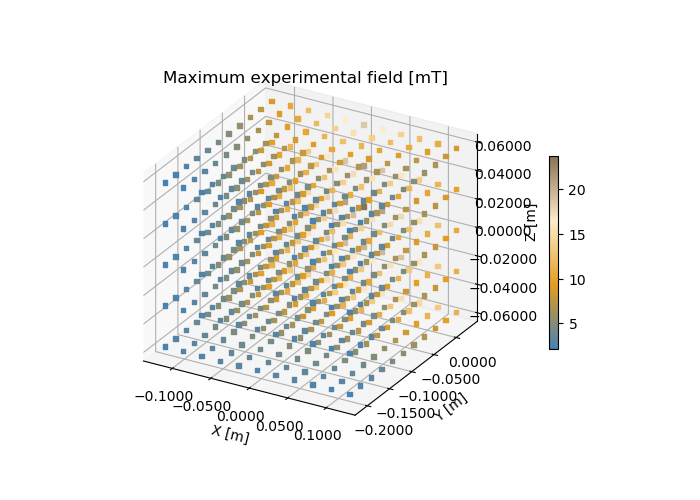

In [20]:
# 3d representation
size_marker = 10

fig = plt.figure(figsize=(7, 5))

ax = fig.gca(projection='3d',proj_type = 'ortho')
s1 = ax.scatter(posm2[:,0],posm2[:,1],posm2[:,2], c=bminm2_mag_ordered, marker="s", cmap = cmp_blue_4col, vmin=bmin, vmax=bmax, alpha=1.,s = size_marker, rasterized=True)
s2 = ax.scatter(posm1[:,0],posm1[:,1],posm1[:,2], c=bminm1_mag_ordered, marker="s", cmap = cmp_blue_4col, vmin=bmin, vmax=bmax, alpha=1.,s = size_marker, rasterized=True)
s3 = ax.scatter(pos0[:,0],pos0[:,1],pos0[:,2], c=bmin_mag_ordered, marker="s", cmap = cmp_blue_4col, vmin=bmin, vmax=bmax, alpha=1.,s = size_marker, rasterized=True)
s4 = ax.scatter(pos1[:,0],pos1[:,1],pos1[:,2], c=bmin1_mag_ordered, marker="s", cmap = cmp_blue_4col, vmin=bmin, vmax=bmax, alpha=1.,s = size_marker, rasterized=True)
s5 = ax.scatter(pos2[:,0],pos2[:,1],pos2[:,2], c=bmin2_mag_ordered, marker="s", cmap = cmp_blue_4col, vmin=bmin, vmax=bmax, alpha=1.,s = size_marker, rasterized=True)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title("Maximum experimental field [mT]")
plt.show()
fig.colorbar(s, ax=ax,shrink=0.5)

### Evaluation of the estimation error

In [31]:
# Compute error in mT
err0 = np.abs(bmax0*1000 - bmin_mag_ordered)
err1 = np.abs(bmax1*1000 - bmin1_mag_ordered)
err2 = np.abs(bmax2*1000 - bmin2_mag_ordered)
errm1 = np.abs(bmaxm1*1000 - bminm1_mag_ordered)
errm2 = np.abs(bmaxm2*1000 - bminm2_mag_ordered)
# Concatenate results in different planes
err = np.concatenate((errm2, errm1, err0, err1, err2))

emin = np.min(err)
emax = np.max(err)

print("Mean absolute error [mT]: ",np.mean(err))
print("Std absolute error [mT]: ",np.std(err))
print("Maximum error [mT]: ",emin)
print("Minimum error [mT]: ",emax)

Mean absolute error [mT]:  0.6145348458403168
Std absolute error [mT]:  0.2938663020356098
Maximum error [mT]:  0.001046869036233744
Minimum error [mT]:  1.3283043698520718


<IPython.core.display.Javascript object>


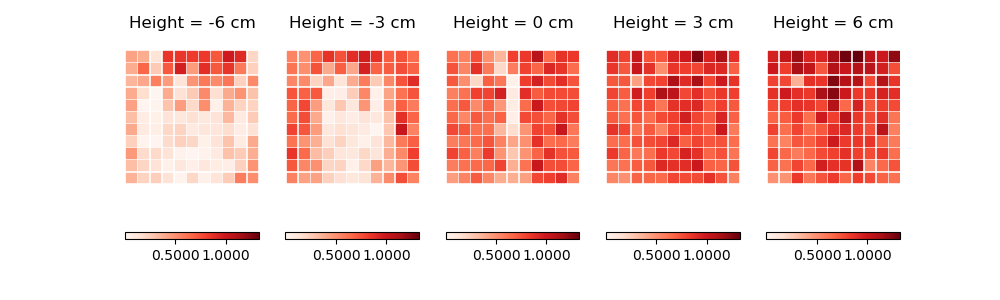

In [32]:


fig = plt.figure(figsize=(10, 3))

# Pos -2
ax = fig.add_subplot(151)
s = ax.scatter(posm2[:,0]*100,posm2[:,1]*100, c=errm2, marker="s", cmap = "Reds", vmin=emin, vmax=emax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = -6 cm')
ax.axis('equal')
ax.axis('off')
fig.colorbar(s, ax=ax,shrink=1.,orientation='horizontal')

# Pos -1
ax = fig.add_subplot(152)
s = ax.scatter(posm1[:,0]*100,posm1[:,1]*100, c=errm1, marker="s", cmap = "Reds",vmin=emin, vmax=emax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = -3 cm')
ax.axis('equal')
ax.axis('off')
fig.colorbar(s, ax=ax,shrink=1.,orientation='horizontal')

# Pos 0
ax = fig.add_subplot(153)
s = ax.scatter(pos0[:,0]*100,pos0[:,1]*100, c=err0, marker="s", cmap = "Reds",vmin=emin, vmax=emax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = 0 cm')
ax.axis('equal')
ax.axis('off')
fig.colorbar(s, ax=ax,shrink=1.,orientation='horizontal')

# Pos 1
ax = fig.add_subplot(154)
s = ax.scatter(pos1[:,0]*100,pos1[:,1]*100, c=err1, marker="s", cmap = "Reds",vmin=emin, vmax=emax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = 3 cm')
ax.axis('equal')
ax.axis('off')
fig.colorbar(s, ax=ax,shrink=1.,orientation='horizontal')

# Pos 2
ax = fig.add_subplot(155)
s = ax.scatter(pos2[:,0]*100,pos2[:,1]*100, c=err2, marker="s", cmap = "Reds",vmin=emin, vmax=emax, alpha=1.,s = 50, rasterized=True)
ax.set_title('Height = 6 cm')
ax.axis('equal')
ax.axis('off')
fig.colorbar(s, ax=ax,shrink=1.,orientation='horizontal')

plt.show()